In [ ]:
import pandas as pd
salaries = pd.read_csv('graduate_salaries.csv', header=13)

In [ ]:
cnames = salaries.columns.values.tolist()

interest_variables = ['Salary band', 'Domicile', 'Percent']
for i in interest_variables:
    cnames.remove(i)

#salary bands are in 3rd column, domicilie in 5th
rvalues = ['Total', 'Total', 'All', 'All', 'All undergraduate', 'All', 'Paid employment is an activity']

count = 0
while count < len(cnames):
    salaries = salaries.loc[salaries[cnames[count]] == rvalues[count]]
    count += 1
    
salaries = salaries.sort_values(['Domicile', 'Salary band'])
salaries = salaries.loc[salaries['Domicile'].isin(['All UK', 'Other European Union', 'Non-European Union'])]

In [ ]:
salaries_new = pd.DataFrame(salaries[interest_variables])
salaries_new = salaries_new.reset_index()
salaries_new = salaries_new.drop(['index'], axis=1)

In [ ]:
# this response rates are from HESA Graduate Outcomes 2017/2018
uk_responses = 190065
eu_responses = 13315
non_eu_responses = 38420

count = 0
amount = []
for i in salaries_new['Domicile']:
    if i == 'All UK':
        amount.append(int(salaries_new['Percent'][count]*uk_responses))
    if i == 'Other European Union':
        amount.append(int(salaries_new['Percent'][count]*eu_responses))
    if i == 'Non-European Union':
        amount.append(int(salaries_new['Percent'][count]*non_eu_responses))
    count += 1

salaries_new['Numbers'] = amount

In [ ]:
import numpy as np
from sklearn.metrics import r2_score

#See appendix A.12 for why minimimum is 14020
minimum = 14020
wages = []
intervals_first = []
counta = 0
srange = salaries_new['Salary band'].str.replace(',', '').str.replace('£', '')
while counta < 2:
    intervals = []
    if counta == 0:
        count = 0
        limit = 9
    if counta == 1:
        count = 20
        limit = 29
    while count < limit:
        count1 = 0
        res = [int(i) for i in srange[count].split() if i.isdigit()]
        if res[0] == 15000 and len(res)==1:
            res.insert(0, minimum)
        distance = float((res[1]-res[0])/(salaries_new['Numbers'][count]))
        intervals.append(distance)
        if counta == 0:
            intervals_first.append(distance)
        val = res[0]
        while count1 < salaries_new['Numbers'][count]:
            val += distance
            wages.append(val)
            count1 += 1
        count += 1
    
    #since don't know final range (e.g. 39000+), make polyinomial regression to best model the final interval. Appendix A.12
    t_int = np.arange(start=0, stop=len(intervals), step=1)
    model_final_distance = np.poly1d(np.polyfit(t_int, intervals, 3))
    final_distance = model_final_distance(9)
    
    # in both cases of EU and UK data, r2 > 0.9
    print("the r2 is", r2_score(intervals, model_final_distance(t_int)))
    
    countb = 0
    while countb < salaries_new['Numbers'][limit]:
        val += final_distance
        wages.append(val)
        countb += 1
    counta += 1

wages_final = pd.DataFrame(wages, columns = ['wages'])
wages_final.sort_values('wages', ascending=True)
wages_final.describe().round(2)

the r2 is 0.9445384623003156
the r2 is 0.9335260960051251


,wages
count,205270.00
mean,25659.27
std,7339.28
min,14020.13
25%,20397.01
50%,24610.21
75%,29535.22
max,55735.38


[0.15422538 0.13759685 0.10986703 0.0914325  0.10268983 0.16403562
 0.29586643 0.51857886 0.85256948]


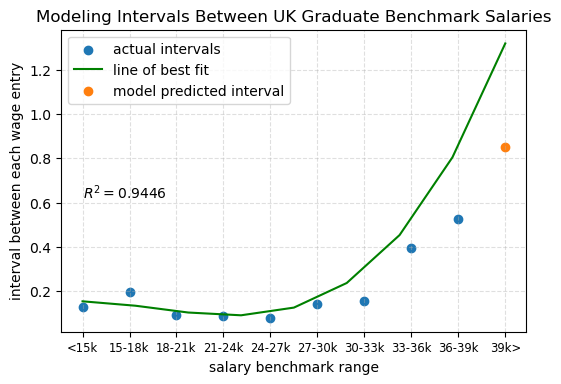

0.9445974048355237
0.8525694845158728


In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.interpolate import make_interp_spline
import numpy as np

    

intervals = [0.12891344, 0.197232, 0.092852951, 0.087661334, 0.078894611, 0.143053475, 0.15772947, 0.394504, 0.5260]
t_int = np.arange(start=0, stop=len(intervals), step=1)
benchmark = ["<15k", "15-18k", "18-21k", "21-24k", "24-27k", "27-30k", "30-33k", "33-36k", "36-39k", "39k>"]

plt.figure(dpi=100)
model = np.poly1d(np.polyfit(t_int, intervals, 3))
plt.scatter(t_int, intervals, label="actual intervals")
myline = np.linspace(0, 9, 9)

print (model(myline))
X_Y_Spline = make_interp_spline(t_int, model(myline))
Y_ = X_Y_Spline(myline)

plt.plot(myline, Y_, color="green", label="line of best fit")
plt.scatter(9, model(9), label="model predicted interval")
plt.legend()
plt.text(0, 0.621, '$R^2 = 0.9446$')
plt.xticks(range(len(benchmark)), benchmark, size='small')
plt.title("Modeling Intervals Between UK Graduate Benchmark Salaries")
plt.ylabel("interval between each wage entry")
plt.xlabel("salary benchmark range")
plt.grid(alpha=.4,linestyle='--')
plt.show()


print(r2_score(intervals, model(t_int)))
print(model(9))


In [90]:
wages_final.to_csv("wages.csv", index= False)